In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set your Kaggle API credentials (make sure to upload your kaggle.json file to your notebook)
os.environ["KAGGLE_USERNAME"] = "ajfunari"
os.environ["KAGGLE_KEY"] = "cb66eed558fe1d91db565e0d279b2fdb"

# # Create a Kaggle API object
api = KaggleApi()
api.authenticate()

# # Specify the dataset you want to download
dataset_name = "tawsifurrahman/covid19-radiography-database"

# # Set the destination folder for the downloaded dataset
current_directory = os.getcwd()
download_path = "/input"
path = current_directory + download_path
print(path)

# # Download the dataset
api.dataset_download_files(dataset_name, path=path, unzip=True)  # 800 MB

c:\Users\flyin\OneDrive - Indiana University\Fall23\Intro to Intelligent Systems\GitHub\Xray_Classification\AJ Test Scripts/input


In [65]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import SubsetRandomSampler, DataLoader

# image directory
all_images = '/input/COVID-19_Radiography_Dataset'

# Set the path to your image folders
all_path = os.getcwd() + all_images

'''
Reshape images to (3,28,28) for homework CNN
'''
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

'''
ImageFolder will store all images in COVID folder and Normal folder into one dataset. Target 0 
is assigned to COVID images. Target 1 is assigned to Normal images.
'''
# Create datasets
dataset = ImageFolder(all_path, transform=transform)  # 10,192 + 3,616 = 13,808
# for i in range(len(dataset)):
#     print(dataset[i])
#     print(dataset[i][0].shape)
#     break

# Shuffle indices to randomize the order of dataset
torch.manual_seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# Define the split ratio for training and testing
train_size = int(0.8 * len(dataset))   # 11,046
test_size = len(dataset) - train_size  # 2762

# Use SubsetRandomSampler for training and testing split
train_sampler = SubsetRandomSampler(indices[:train_size])
test_sampler = SubsetRandomSampler(indices[train_size:])

# Create Dataloaders instances for training and testing
train_loader = DataLoader(dataset, batch_size=50, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=50, sampler=test_sampler)

# print(len(train_loader))
# print(len(test_loader))

In [66]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels)
    break

torch.Size([50, 3, 28, 28])
tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1])


In [62]:
import torch.nn as nn
from CNN import CNN

# Hyper paramters
learning_rate = 0.01
num_epochs = 10

# Create an instance of model
model = CNN()

# Loss
criterion = nn.CrossEntropyLoss()
# Stochastic Gradient Descent with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5) # stochastic gradient descent

# Store training loss
training_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            training_loss.append(loss.item())

Epoch [1/10], Step [10/221], Loss: 1.6899
Epoch [1/10], Step [20/221], Loss: 0.6164
Epoch [1/10], Step [30/221], Loss: 0.5963
Epoch [1/10], Step [40/221], Loss: 0.6763
Epoch [1/10], Step [50/221], Loss: 0.6062
Epoch [1/10], Step [60/221], Loss: 0.6432
Epoch [1/10], Step [70/221], Loss: 0.5243
Epoch [1/10], Step [80/221], Loss: 0.5873
Epoch [1/10], Step [90/221], Loss: 0.5416
Epoch [1/10], Step [100/221], Loss: 0.5952
Epoch [1/10], Step [110/221], Loss: 0.5568
Epoch [1/10], Step [120/221], Loss: 0.5398
Epoch [1/10], Step [130/221], Loss: 0.4058
Epoch [1/10], Step [140/221], Loss: 0.4752
Epoch [1/10], Step [150/221], Loss: 0.6003
Epoch [1/10], Step [160/221], Loss: 0.6517
Epoch [1/10], Step [170/221], Loss: 0.4049
Epoch [1/10], Step [180/221], Loss: 0.9017
Epoch [1/10], Step [190/221], Loss: 0.3993
Epoch [1/10], Step [200/221], Loss: 0.4751
Epoch [1/10], Step [210/221], Loss: 0.4932
Epoch [1/10], Step [220/221], Loss: 0.9229
Epoch [2/10], Step [10/221], Loss: 0.6162
Epoch [2/10], Step [2

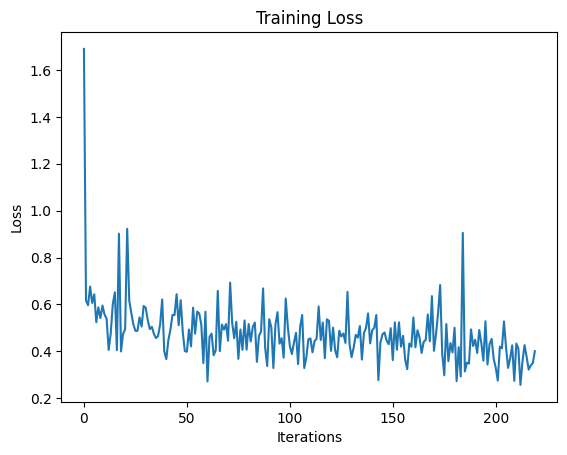

In [63]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure()
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(training_loss)
plt.show()

Test accuracy: 81.49891383055757%


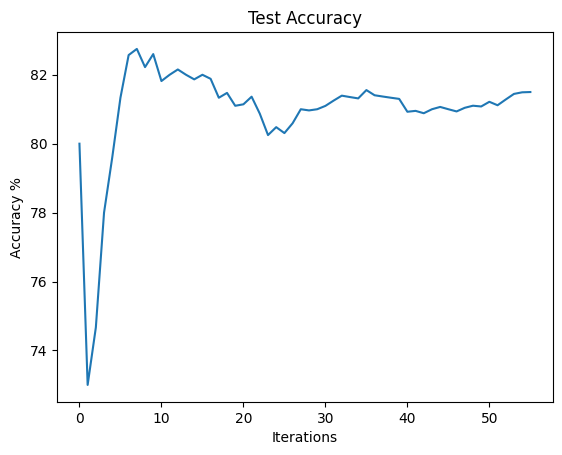

'\nBatch Size = 50\nLearning Rate = 0.01\nEpochs = 10\nImages were normalized\nACCURACY = 87.87%\n'

In [64]:
# Store test accuracy
test_accuracy = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)  # send batch of images through CNN
        # Tensor.data = tensor
        _, predicted = torch.max(outputs.data, 1)  # extract highest predicted value
        # Tensor.size(): torch.Size, Tensor.size(0): int
        total += labels.size(0)
        # Tensor.item(): number
        correct += (predicted == labels).sum().item()
        # Store test accuracy per minibatch (200 batches w/ 50 images)
        accuracy = (correct/total)*100
        test_accuracy.append(accuracy)
    print(f"Test accuracy: {(correct/total)*100}%")

# Plot test accuracy
plt.figure()
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy %")
plt.plot(test_accuracy)
plt.show()

'''
Batch Size = 50
Learning Rate = 0.01
Epochs = 10
ACCURACY = 87.87% (images normalized)
ACCURACY = 81.49% (images not normalized)
'''

In [67]:
'''
Reshape images to (3,224,224) for AlexNet
'''
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Create datasets
dataset = ImageFolder(all_path, transform=transform)  # 10,192 + 3,616 = 13,808 images

# Shuffle indices to randomize the order of dataset
torch.manual_seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# Define the split ratio for training and testing
train_size = int(0.8 * len(dataset))   # 11,046
test_size = len(dataset) - train_size  # 2762

# Use SubsetRandomSampler for training and testing split
train_sampler = SubsetRandomSampler(indices[:train_size])
test_sampler = SubsetRandomSampler(indices[train_size:])

# Create Dataloaders instances for training and testing
train_loader = DataLoader(dataset, batch_size=50, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=50, sampler=test_sampler)

In [68]:
from AlexNet import AlexNet

# Hyper paramters
learning_rate = 0.01
num_epochs = 10

# Create an instance of model
model = AlexNet()

# Loss
criterion = nn.CrossEntropyLoss()
# Stochastic Gradient Descent with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5) # stochastic gradient descent

# Store training loss
training_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            training_loss.append(loss.item())

Epoch [1/10], Step [10/221], Loss: 0.6705
Epoch [1/10], Step [20/221], Loss: 0.6294
Epoch [1/10], Step [30/221], Loss: 0.5883
Epoch [1/10], Step [40/221], Loss: 0.6149
Epoch [1/10], Step [50/221], Loss: 0.5133
Epoch [1/10], Step [60/221], Loss: 0.4835
Epoch [1/10], Step [70/221], Loss: 0.5679
Epoch [1/10], Step [80/221], Loss: 0.6091
Epoch [1/10], Step [90/221], Loss: 0.5592
Epoch [1/10], Step [100/221], Loss: 0.4739
Epoch [1/10], Step [110/221], Loss: 0.6391
Epoch [1/10], Step [120/221], Loss: 0.5872
Epoch [1/10], Step [130/221], Loss: 0.6508
Epoch [1/10], Step [140/221], Loss: 0.5918
Epoch [1/10], Step [150/221], Loss: 0.4699
Epoch [1/10], Step [160/221], Loss: 0.6004
Epoch [1/10], Step [170/221], Loss: 0.5733
Epoch [1/10], Step [180/221], Loss: 0.5272
Epoch [1/10], Step [190/221], Loss: 0.5296
Epoch [1/10], Step [200/221], Loss: 0.3982
Epoch [1/10], Step [210/221], Loss: 0.5023
Epoch [1/10], Step [220/221], Loss: 0.5004
Epoch [2/10], Step [10/221], Loss: 0.4426
Epoch [2/10], Step [2

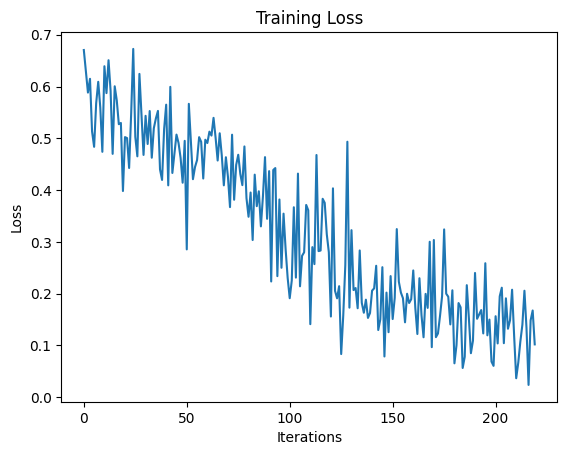

In [69]:
# Plot training loss
plt.figure()
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(training_loss)
plt.show()

Test accuracy: 95.32947139753801%


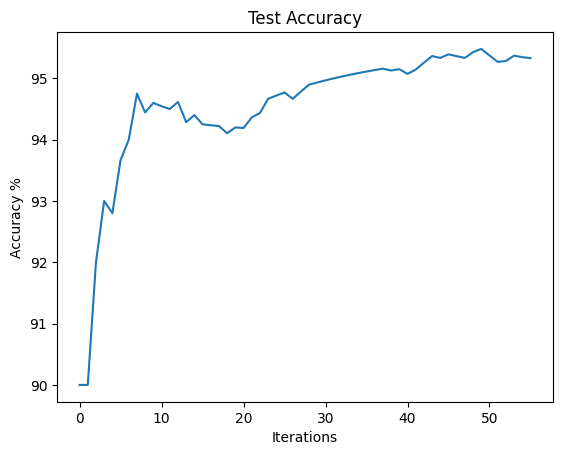

'\nBatch Size = 50\nLearning Rate = 0.01\nEpochs = 10\nACCURACY = 95.47% (images normalized)\n'

In [73]:
# Store test accuracy
test_accuracy = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)  # send batch of images through CNN
        # Tensor.data = tensor
        _, predicted = torch.max(outputs.data, 1)  # extract highest predicted value
        # Tensor.size(): torch.Size, Tensor.size(0): int
        total += labels.size(0)
        # Tensor.item(): number
        correct += (predicted == labels).sum().item()
        # Store test accuracy per minibatch (200 batches w/ 50 images)
        accuracy = (correct/total)*100
        test_accuracy.append(accuracy)
    print(f"Test accuracy: {(correct/total)*100}%")

# Plot test accuracy
plt.figure()
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy %")
plt.plot(test_accuracy)
plt.show()

'''
Batch Size = 50
Learning Rate = 0.01
Epochs = 10
ACCURACY = 95+% (images normalized)
'''